# Optimising OpenCL applications

Optimal performance for OpenCL applications is a complex multi-dimensional problem. It depends not only on peak utilisation of compute units, but also the timeliness and speed that memory is passed in and out of compute units. It is a general rule that vendor-specific libraries are the best way to achieve optimal compute performance, however for OpenCL these libraries are often not available. At the same time OpenCL implementations and their underlying hardware have smart technologies to optimise processing for commonly used computing operations, and sometimes the simplest approach works best. At other times better compute performance comes at a significant increase in complexity of the program. CPU's and GPU's architectures are optimsed for different ways of computing. This means that a kernel that performs well on a CPU might perform poorly on a GPU, and vice-versa. Experimentation is the key. In the following sections we will try a number of experiments and see what kind of difference they make to the matrix multiplication problem.

## Fundamentals of CPU and GPU architectures

It is helpful to first cover the fundamentals of computer architectures and explore differences between CPU's and GPU's. 

### Hardware threads and processing elements

From the introduction we have seen that that a processor is partioned into cores and each core provides a number of hardware threads that become the processing elements for an OpenCL kernel. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/Intel-8th-Gen Core-3.jpg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A processor die showing an eighth-generation <span>Intel&trade;</span> <span>Core&trade;</span> processor. Image used with permission courtesy of Intel Corporation. </figcaption>
</figure>

Cores have a clock cycle and can perform a limited number of instructions per cycle. During a computation instructions such as math commands are executed on the hardware threads, using memory that is passed in and out of the core from a hierarchy of caches. If this memory does not arrive on time, or get disposed of on time, then the hardware threads will stall and peak theoretical performance will not be acheived.

### Cache topics

#### Hierarchy

The fastest memory in a processor (CPU or GPU) are the registers. They operate at or near the same clock speed as the CPU and are located on the CPU die. This memory is not cheap however, and memory for a computation is shuffled to and from the processor through a hierarchy of caches with the following sizes and locations:

* Register, fastest memory (few kB)
* L1 cache, fast on-die memory (tens of kB)
* L2 cache, fast on-die memory (hundreds of kB)
* L3 cache, fast memory near the device or on-die. (few MB to tens of MB)
* Global or device memory (RAM, few GB onwards)

The most used memory is stored in the lowest level caches. Memory that is not used as often is evicted to the slower caches as necessary. Memory that is rarely at all is flushed out to global memory.

#### Cache lines - the fundamental unit of memory transactions

Memory passed from caches doesn't arrive at the CPU in units of individual bytes, instead it arrives in transactional units called cache lines. Cache lines are around 64-128 bytes, which can store 16-32 floating point numbers.

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/cache_line.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A cache line 64 bytes wide. </figcaption>
</figure>

This means that if a processor needs to fetch from or store a value in memory, then the cache hierarchy must transport the **entire cache line** in which the value is located. Caches have slots in them where cache lines can be stored, however if a cache line is not in the faster caches, then it must be fetched from main memory at the cost of wasted processor cycles. 

> A key to achieving good performance with memory is to then **try and use as many neighbouring elements in cache line as possible** by subsequently fetching and storing memory that is in the immediate "neighbourhood" of the initial memory access. 

In the context of OpenCL it is advantageous if a work-item or work-items in a workgroup access neighbouring memory locations. Then memory transfers can be combined in what is known as **coalesced memory access**.

#### Latency

Latency is the number of cycles a processing element has to wait for memory to arrive from a cache. here are some indicative numbers on latency for CPU and GPU caches.

| Cache | memory latency (clock cycles on a CPU) | memory latency (clock cycles on a GPU)
|:----:|-----:|-----:|
|   Register  | ~1 | ~20 |
|   L1  | ~4 | ~30-100|
| L2 | ~12 | ~175-300 |
| L3 | ~24-32 | NA |
| Device memory | >= 100 | 300-800 | 

Sources for these numbers: [GPU numbers 1](http://lpgpu.org/wp/wp-content/uploads/2013/05/poster_andresch_acaces2014.pdf), [GPU numbers 2](https://arxiv.org/pdf/1804.06826.pdf), [CPU numbers](http://techreport.com/review/27018/intel-xeon-e5-2687w-v3-processor-reviewed/4).

#### Throughput

Throughput is a measure of how fast memory can be transported from a cache to the processing element. As follows is a rough guide on what one can expect to see from CPU and GPU cache throughput.

| Cache | speed (GB/s on a CPU) | speed (GB/s on a GPU) |
|:----:|-----:|-----:|
|   L1  | 2000-4000 | ~1000+ |
| L2 | 1000-1500 | ~1000 |
| L3 | 500-1000 |NA|
| Device memory | 16 - 128 | 100-1200 |

Sources for these numbers: [CPU numbers](http://www.tested.com/tech/457440-theoretical-vs-actual-bandwidth-pci-express-and-thunderbolt), [GPU numbers](http://meseec.ce.rit.edu/551-projects/spring2015/3-2.pdf)

#### Thoughts on latency and throughput with OpenCL kernels in mind

With either CPU or GPU processors we must make sure to make best use of cache lines. This means creating workgroups whose neighbouring work items also work on neighbouring elements of a memory allocation. It seems that throughput from global memory is significant faster on a GPU device, however memory will take more cycles to arrive. 

### Floating point operations

Math operations (such as multiply or add) on floating point numbers are an essential component of scientific applications. These operations are typically performed on 32- or 64-bit numbers, however 16-bit operations are becoming popular in machine learning as those do not require extremely precise calculations. Performance of a processor is measured in FLOPS, or the total number of floating point operations its compute units can perform in one second. At the time of writing units of gigaFLOPS ($10^{9}$ FLOPS) or teraFLOPS ($10^{12}$ FLOPS) are commonly used to describe compute device performance.

The raw floating point performance of a compute device is very much dependent on precision and wether or not the architecture is built for it. Gaming hardware is often optimised for 32-bit floats, and 64-bit processing may be emulated in software or accomplished with fewer cores. For example the RTX3060 graphics card has a 64-bit floating point processing rate that is **64 times lower** than 32-bit due to 64 times fewer 64-bit capable cores. CPU's have SIMD processing units that can process vectors of floats with a single instruction. At the time of writing vectors of up to 512 bits (16 floats) can be processed by AVX-512 instructions.

Compute performance within a kernel is also determined by the type of math instruction performed. 
> Addition, multiplication, and fused multiply-add are among the **cheapest** operations to perform (costing a few processor cycles), whereas division, square-root, and trigonometric functions are typically an **order of magnitude** more expensive. Writing your kernels to minimise expensive math operations will help, but waiting for memory is time consuming, and during those times kernel math can often be done for free.

### CPU architecture specifics

CPU's usually have fewer than 100 cores, but each core has sophisticated instruction handling and nice things like pre-emptive memory fetching and branch prediction. One can think of CPU cores as smart workers, and the cache latency timings above means they are more nimble than GPU's. CPU's have registers, and on-die L1 and L2 caches. The L3 cache is usually also on-die, but is in an area that is commonly accessible to other cores. In <span>AMD&trade; Zen&trade; 3+</span>  CPU's the cores are grouped in chiplets of 8 cores called core complexes (CCX's), and the L3 cache is located in an area of the chiplet with access from each core. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:100%">
    <img style="vertical-align:middle" src="../images/cpu_cores.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: Section of a CPU processor, showing cores with floating point SIMD units and integer pipelines. </figcaption>
</figure>

With OpenCL we might be able to use [clCreateSubDevices](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateSubDevices.html) to partition a CPU into sub-devices, so that workgroups can run on a single chiplet. In terms of math operations, CPU's have integer processing and SIMD (Single Instruction Multiple Data) units that can process vectors of floating point numbers. At the time of writing vectors of up to 8-16 floats (AVX2-AVX512) may be processed at a time using the SIMD units of a CPU. It depends largely on what kind of vector instructions are supported by the chipset.

> Getting good floating point performance from a CPU is **critically** dependent on wether or not one can effectively leverage the SIMD units of the CPU. Using **vectors** in OpenCL kernel is a way for the implementation's device compiler to emit vector instructions that work on the CPU.

#### Example specifications

Here are some of the top CPU's at the moment and their specs.

| CPU | Base clock frequency (GHz) | Cores | Hardware threads | L1 Cache (KB) | L2 Cache (KB) | L3 cache (MB) | FP SIMD width (bits) | Tflops (FP32 calculated) |
|:----:|-----:| -----: | -----: | :----: | :----: | :----: | :----: | :----: |
| Intel Xeon Platinum 8380HL | 2.9 | 28 | 56 | 28x64 | 28x1024 | 38.5 | 512 | 1.3 |
| AMD EPYC 7H12 | 2.6 | 64 | 128 | 64x32 | 64x512 | 16x16 | 256 | 1.3 |

Source for the CPU specs [Xeon](http://www.cpu-world.com/CPUs/Xeon/Intel-Xeon%20E7-4850%20v4.html) and [Epyc](https://en.wikipedia.org/wiki/Epyc).

### GPU architecture specifics

There is some confusing terminology surrounding the definition of a processor core in GPU's. GPU's also have processor cores, called **Streaming Multiprocessors** in NVIDIA terminology, **Compute Units** in AMD terminology, and **Xe-Cores** in Intel terminology. Each of these cores schedule instructions and move data in the caches. Instructions are executed in lock-step, over teams of hardware threads. Data for each hardware thread lives in the registers and is manipulated by individual SIMD-like processing elements with floating point capabilities. The terminology for thread teams is called SIMT (Single Instruction Multiple Thread), and individual elements are called **CUDA Cores** in NVIDIA terminology, and **Shader cores** in AMD terminology. The teams are known as **Warps** in NVIDIA terminology and **Wavefronts** in AMD. Teams are 32-64 work items large on NVIDIA hardware, and 64 work items large on AMD hardware.  It appears that Intel have adopted a hybrid approach in using both SIMT and SIMD in their vector units, so using vector instructions will be critical in unlocking performance with OpenCL.

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:80%">
    <img style="vertical-align:middle" src="../images/gpu_cores.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: Floating point units (FP32), registers, and caches for different GPU's. </figcaption>
</figure>

In a GPU there are several cores, and this means that there are thousands of processing elements available to run a kernel on.

> There are a few things to note with the SIMT approaches of NVIDIA and AMD. First of which is that instructions are executed in lock-step. This means that the **ideal workgroup size is going to be a multiple of the work-items in a warp or wavefront**. You can get the the preferred workgroup size using **clinfo** or querying for the **CL_KERNEL_PREFERRED_WORK_GROUP_SIZE_MULTIPLE** attribute for a compiled kernel with [clGetKernelWorkGroupInfo](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetKernelWorkGroupInfo.html). Secondly, branching (using if statements in kernels with multiple execution paths) can be costly, as the whole team must execute all branches sequentially regardless of wether or not work is done. Next, we note there are **many** times more hardware threads available with GPU's, so you need to schedule enough work-items to keep those threads busy. This is known as **occupancy**. Finally, it is important to note that it is the processor core (Streaming Multiprocessor, Compute Unit, or Xe core) that schedules instructions, the individual processing elements are by design not as sophisicated as their CPU counterparts. 

#### Matrix and tensor cores not available in OpenCL

Up to this point I have completely skipped over the extra matrix (AMD, INTEL) and tensor (NVIDIA) core functionality present in modern GPU's. This special matrix processing machinery has applications in machine learning. Unfortunately this ability is not present in OpenCL and at the time of writing can only be unlocked through vendor implementations.

#### Example GPU specifications

Here are some specifications on more recent GPU's. AMD has a more SIMD-like approach to computing floats. Therefore they don't have their own dedicated 64-bit processing elements. Instead 64 bit processing is either emulated or running at half that of 32-bit floats.

| Card | Boost clock (GHz)| Compute Units | FP32 Processing Elements | FP64 Processing Elements (equivalent compute capacity) | L1 Cache (KB) | L2 Cache (KB) | device memory (GB) | Peak Tflops (FP32)| Peak Tflops (FP64)|
|:----:|:-----| :----- | :----- | :---- | :---- | :---- | :---- | :---- | :---- |
| NVIDIA Tesla K40 | 0.875 | 15 | 2880 | 960 | 48 | 1536 | 12 |5.04|1.68|
| NVIDIA Tesla M60 |1.178 |32| 4096| NA | 32x2x48 | 3072 | 8 |4.8|0.151|
| NVIDIA Tesla P100 |1.480| 56 | 3584 | 1792 | 56x64| 4096 | 16 |10.6|5.3|
| NVIDIA Tesla V100 |1.530| 80 | 5120 | 2560 | 80x96 | 6144 | 16 |15.7|7.8|
| NVIDIA Tesla A100 |1.410| 108 | 6912 | 3456 | 108x164 | 40960 | 40 |19.5|9.7|
| AMD Radeon Instinct MI6 |1.233| 36 | 2304 |  | 36x16 | 2000 | 16 |5.73|0.358|
| AMD Radeon Instinct MI8 |1.000| 64 | 4096 |  | 64x16 | 2000 | 4 |8.2|0.512|
| AMD Radeon Instinct MI25 |1.501 | 64 | 4096 |  | 64x16 | 4000 | 16 |12.3 |0.768|
| AMD Radeon Instinct MI50 |1.746 | 60 | 3840 |  | 60x16 | 4000 | 16 |13.4 |6.7|
| AMD Radeon Instinct MI100 |1.502 | 120 | 7680 |  | 120x16 | 8000 | 32|23.1 |11.5|
| AMD Radeon Instinct MI200 |1.7 | 208 | 13312 |  | 208x16 | 16000 | 128 | 90.5 | 45.3 |
| AMD Radeon Instinct MI250x |1.7 | 220 | 14080 |  | 220x16 | 16000 | 128 | 95.7 | 47.9 |

Source for these numbers [Acceleware](https://training.acceleware.com/blog/Tesla-Meets-Maxwell), [NVIDIA](https://devblogs.nvidia.com/inside-volta/), [AMD](https://www.amd.com/en/graphics/servers-radeon-instinct-mi), [Microway](https://www.microway.com/knowledge-center-articles/in-depth-comparison-of-nvidia-tesla-maxwell-gpu-accelerators/), and [TechPowerup](https://www.techpowerup.com/gpudb/2760/tesla-m60).

## Optimising the use of your compute devices

With these principles in mind we can go about exploring ways to improve performance on the matrix multiplication problem.

### Arithmetic intensity and working out where to spend the effort

The **Arithmetic intensity** is the ratio of FLOPS computed per Byte transferred to the processing element. It helps us determine if our algorithm is likely to be constrained by bandwidth or floating point performance. For our problem matrix A is of size ($N0_{C}, N1_{A}$) and B is of size ($N1_{A}, N1_{C}$), every element computed in matrix C requires $N1_A$ loads from A, $N1_A$ loads from B, and 1 store to C. It also requires $N1_A$ multiplications and $N1_A$ additions. The arithmetic intensity is then

$$ FB = \frac{2N1_A}{(2N1_A+1)b} $$

where **b** is the number of bytes stored per element. When $N1_A$ is large the **FB** ratio for matrix multiplication is then

$$ FB \approx \frac{1}{b} $$

If a processor has a peak performance of $P_{\mbox{max}}$ FLOPS and a peak bandwidth of $\beta_{\mbox{max}}$ bytes per second, then the problem will be constrained by the device's memory bandwidth if $FB < \frac{P_{\mbox{max}}}{\beta_{\mbox{max}}}$. For example, the AMD Mi250x GPU has a peak 32-bit floating point rate of 95.7 TFLOPS and a peak memory bandwidth of 3.2 TB/s. Problems will be constrained by memory bandwidth up to an arithmetic intensity of 

$$FB_{max}=\frac{95.7}{3.2} \approx 30$$

for more information see the [Wikipedia Article on Roofline Models](https://en.wikipedia.org/wiki/Roofline_model).

Usually the critical **$FB_{\mbox{max}}$** ratio for processors is much larger than $\frac{1}{b} $. What this means for the matrix multiplication problem is the following:

* Usually are not going to get anywhere the rated peak performance of the compute device.
* Optimising memory transfers is where we should concentrate our efforts.
* We can likely get most of compute operations done during memory transfers.
* Speedups over a CPU implementation are more likely to be limited to the difference in memory bandwidth speeds.

### Data precision

In scientific computing the precision and range of 64-bit arithmetic is important, for example in the solution of sensitive differential equations. Compute hardware is often optimised for 32-bit floats though, and if your algorithm supports it you can gain an optimisation by running at lower precision. In the example below we run a matrix multiplication problem at 64-bit and 32-bit to see how much of a difference it makes to kernel execution.

In [1]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

dtype=np.float64
NCOLS_A = 1025
NROWS_C = 1025
NCOLS_C = 1025

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

Run the matrix multiplication with 64-bit precision.

In [27]:
!make;
dtype=np.float64
mat_mul_double=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul_double.make_data()

local_opt_double=py_helper.LocalOpt2D(2)
local_opt_double.make_data()

local_opt_double.run_problem(["./mat_mult_double.exe","-gpu"], plot=False)

make: Nothing to be done for 'all'.
	               name: gfx906:sramecc+:xnack- 
	 global memory size: 17163 MB
	    max buffer size: 14588 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
returncode is 0
Min time is 6.419 ms, at the local size of (1,256).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
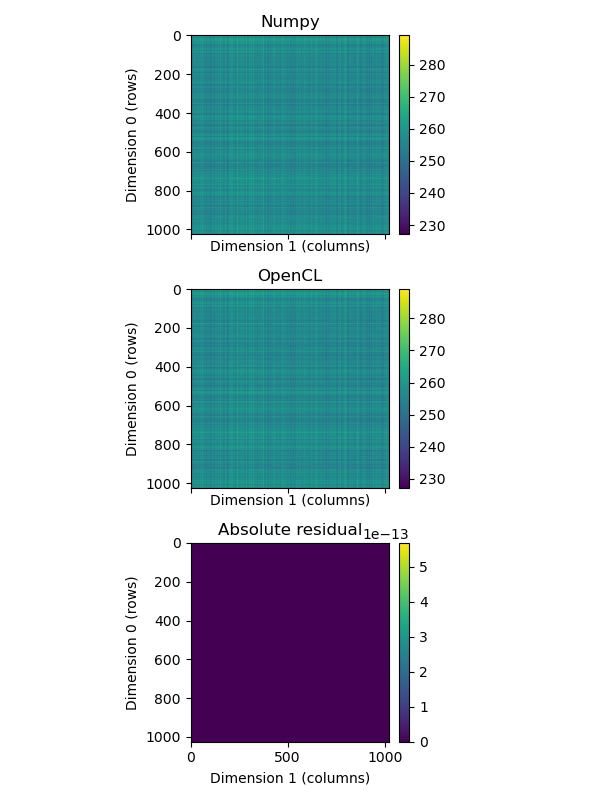

In [28]:
mat_mul_double.check_data()

In [26]:
!make;
dtype=np.float32
mat_mul_float=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul_float.make_data()

local_opt_float=py_helper.LocalOpt2D(2)
local_opt_float.make_data()
local_opt_float.run_problem(["./mat_mult_float.exe","-gpu"], plot=False)

make: Nothing to be done for 'all'.
	               name: gfx906:sramecc+:xnack- 
	 global memory size: 17163 MB
	    max buffer size: 14588 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
returncode is 0
Min time is 3.511 ms, at the local size of (4,32).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
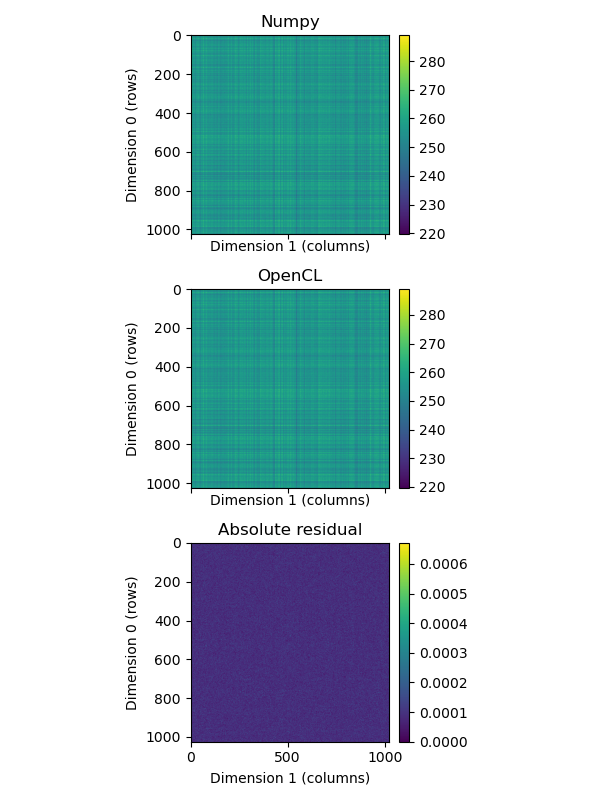

In [24]:
mat_mul_float.check_data()

### Occupancy

### Local size optimisation

### Prefetching

### Using constant memory

### Transposing memory

### Using local memory

### Using vectors

### Device partitioning

### Using Multiple devices

## Optismising IO to your compute devices

* Shared Virtual Memory
* Pinned memory and DMA transfers
* Overlapping IO with compute


### Research papers

* [Using OpenCL on CPUs](https://www.hindawi.com/journals/sp/2015/859491/)

In [3]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

dtype=np.float32
NCOLS_A = 1025
NROWS_C = 1025
NCOLS_C = 1025

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul.make_data()

local_opt=py_helper.LocalOpt2D(2)
local_opt.make_data()

In [4]:
!make; 
data_mat_mult=local_opt.run_problem(["./mat_mult_double.exe","-gpu", "1"])

g++ -g -O2 -fopenmp -I/usr/include -I../include -L/usr/lib64 mat_mult_double.cpp\
	-o mat_mult_double.exe -lOpenCL -lomp
In file included from mat_mult_double.cpp:15:0:
../include/cl_helper.hpp: In function ‘_cl_command_queue** h_create_command_queues(_cl_device_id**, _cl_context**, cl_uint, cl_uint, cl_bool, cl_bool)’:
../include/cl_helper.hpp:316:9: warning: ‘_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)’ is deprecated [-Wdeprecated-declarations]
         );
         ^
In file included from /usr/include/CL/opencl.h:24:0,
                 from ../include/cl_helper.hpp:16,
                 from mat_mult_double.cpp:15:
/usr/include/CL/cl.h:1906:1: note: declared here
 clCreateCommandQueue(cl_context                     context,
 ^~~~~~~~~~~~~~~~~~~~


FileNotFoundError: [Errno 2] No such file or directory: './mat_mult.exe'

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
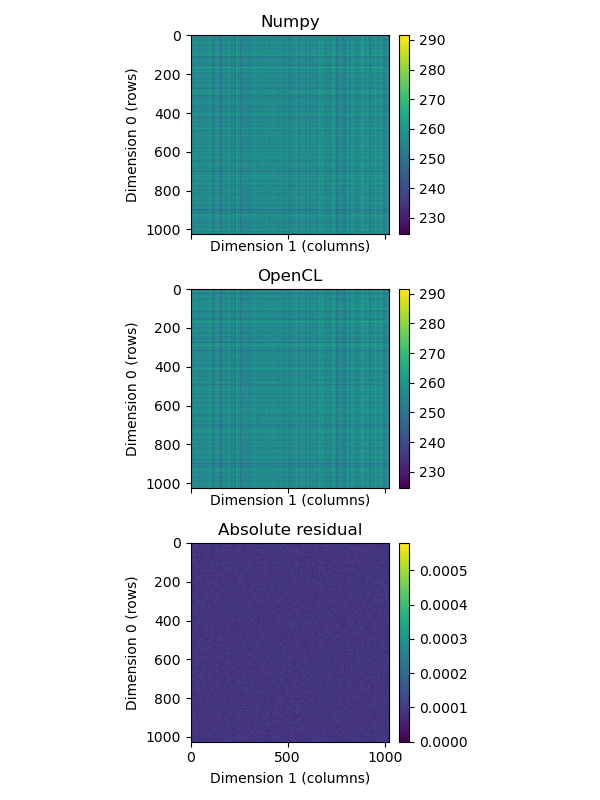

In [17]:
mat_mul.check_data()

### Access to vector elements

Buffer allocations of memory can be interpreted as vectors up to 16 elements. This is a potential source of optimisation because 

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_shmem_transp.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using local memory in matrix multiplication.</figcaption>
</figure>

In [7]:
!make; ./mat_mult_local_transpose_vector.exe -gpu 1

make: Nothing to be done for 'all'.
	               name: NVIDIA GeForce RTX 3060 
	 global memory size: 12635 MB
	    max buffer size: 3158 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Time for event "Running transpose kernel": 0.015 ms
Time for event "Running mat_mul_transp_vec kernel": 1.101 ms


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
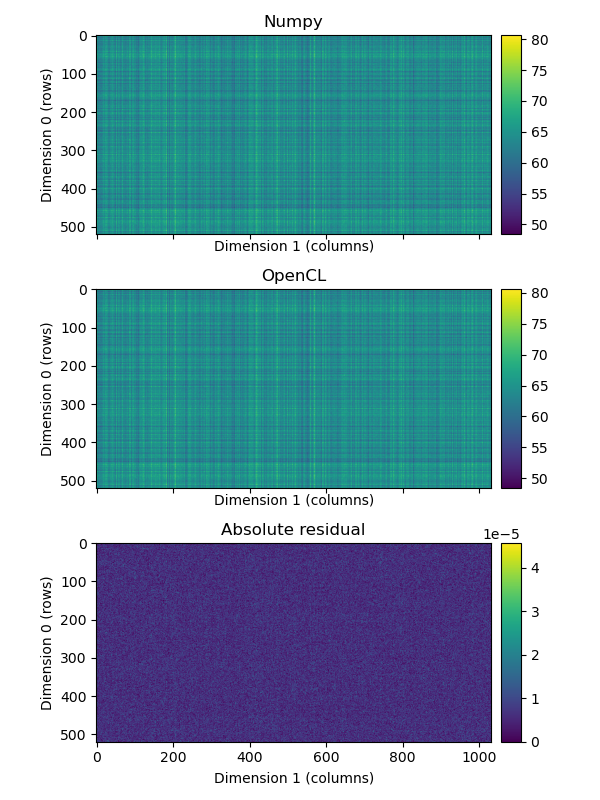

In [8]:
# Import axes machinery
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read in the output from OpenCL
C_ocl = np.fromfile("array_C.dat", dtype=dtype).reshape((NROWS_C, NCOLS_C))

# Make plots
fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True, sharey=True)

# Data to plot
data = [C, C_ocl, np.abs(C-C_ocl)]

# Labels to plot
labels = ["Numpy", "OpenCL", "Absolute residual"]

for n, value in enumerate(data):
    # Plot the graph
    ax = axes[n]
    im = ax.imshow(value)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Set labels on things
    ax.set_xlabel("Dimension 1 (columns)")
    ax.set_ylabel("Dimension 0 (rows)")
    ax.set_title(labels[n])

    # Put a color bar on the plot
    plt.colorbar(mappable=im, cax=cax)

fig.tight_layout()
plt.show()